In [1]:
import os
import torch
import pickle
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

In [2]:
#sample.py
from torchvision import transforms 
from build_vocab import Vocabulary

In [3]:
#train.py
from data_loader import get_loader

In [4]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        print(features.size())
        inputs = features.unsqueeze(1)
        print(inputs.size())
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## Testing the currently training captioning model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
vocab_path = "data/vocab.pkl"
encoder_path = "models/encoder-2-1000.ckpt"
decoder_path = "models/decoder-2-1000.ckpt"

# Model parameters

embed_size = 256
hidden_size = 512
num_layers = 1

In [25]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models

In [27]:
%%time
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

CPU times: user 1.23 s, sys: 390 ms, total: 1.62 s
Wall time: 1.62 s


In [28]:
%%time
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

CPU times: user 230 ms, sys: 100 ms, total: 330 ms
Wall time: 17.7 s


# Prepare an image

In [50]:
# file_path = "png/skater.png"
# file_path = "png/mountains.png"
# file_path = "png/batter.png"
# file_path = "png/two_girls_on_rock.png"
# file_path = "png/girl_on_rock.png"
file_path = "png/kids-beach-playing-600jt082213.jpg"
image = load_image(file_path, transform)
if image.shape[2] > 3:
    image = image[:,:3]
image_tensor = image.to(device)
print(image.shape)

torch.Size([1, 3, 224, 224])


# Generate a caption from the image

In [51]:
%%time
feature = encoder(image_tensor)

CPU times: user 18 ms, sys: 999 µs, total: 19 ms
Wall time: 17.8 ms


In [52]:
%%time
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

torch.Size([1, 256])
torch.Size([1, 1, 256])
CPU times: user 8 ms, sys: 1 ms, total: 9 ms
Wall time: 8.19 ms


In [53]:
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption

In [54]:
sentence = ' '.join(sampled_caption)
print (sentence)

<start> a group of people playing frisbee on a beach . <end>


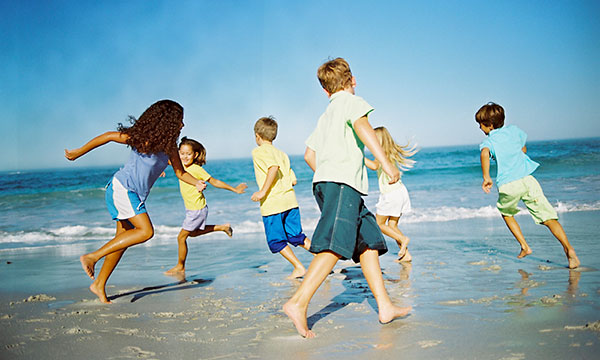

In [66]:
image = Image.open(file_path)
image

## Notes

 - 9956 words in our vocabulary
 - created a vocab class with word_to_idx and idx_to_word attributes (dicts) using pycocotools
 - a minimum word count threshold of 4 was chosen as default value to identify and remove rare words

Notes on adversarial examples:
 - for some reason beach is linked to frisbee

# Now try some model training

###  Define parameters and filepaths

In [17]:
class Args():
    model_path = 'nb_models'
    crop_size = 224
    vocab_path = 'data/vocab.pkl'
    image_dir = 'data/resized2014'
    caption_path = 'data/annotations/captions_train2014.json'
    log_step = 10
    save_step = 1000
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    num_epochs = 1
    batch_size = 128
    num_workers = 2
    learning_rate = 0.001
args = Args()

In [18]:
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

### Image preprocessing, normalization for the pretrained resnet

In [70]:
transform = transforms.Compose([ 
    transforms.RandomCrop(args.crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

### Load vocabulary wrapper

In [56]:
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)
print("Size of Vocabulary: %d" % len(vocab))

Size of Vocabulary: 9956


### Build data loader

In [71]:
data_loader = get_loader(args.image_dir, args.caption_path, vocab, 
                         transform, args.batch_size,
                         shuffle=True, num_workers=args.num_workers)

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!


### Build the models

In [72]:
encoder = EncoderCNN(args.embed_size).to(device)
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers).to(device)

### Loss and optimizer

In [73]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=args.learning_rate)

20.46 p.m.

### Train the models


In [74]:
total_step = len(data_loader)
for epoch in range(args.num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % args.log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

        # Save the model checkpoints
        if (i+1) % args.save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

Epoch [0/1], Step [0/3236], Loss: 9.2120, Perplexity: 10016.3702


Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/nv/hp22/ashanker9/data/anaconda/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/

KeyboardInterrupt: 

In [78]:
images = images.to(device)
captions = captions.to(device)
targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

# Forward, backward and optimize
features = encoder(images)
outputs = decoder(features, captions, lengths)


In [79]:
loss = criterion(outputs, targets)

In [80]:
decoder.zero_grad()
encoder.zero_grad()
loss.backward()
optimizer.step()
print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
      .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

Epoch [0/1], Step [5/3236], Loss: 6.9198, Perplexity: 1012.0966


In [346]:
# Loop for complete training